# IMPORTS


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2 as cv

import torch
from torchvision import datasets, transforms
from torchvision.transforms import Pad

import utils.utilities as utl

import utils.preprocessing as pp
from utils.utilities import Loader

CHECK FOR GPU PROCESSING AVAILABILITY

In [3]:
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


## LOADERS

In [33]:
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

val_loader: Loader = utl.Loader(VAL_PATH, transform=transform)

In [34]:
val_loader.get_loader()

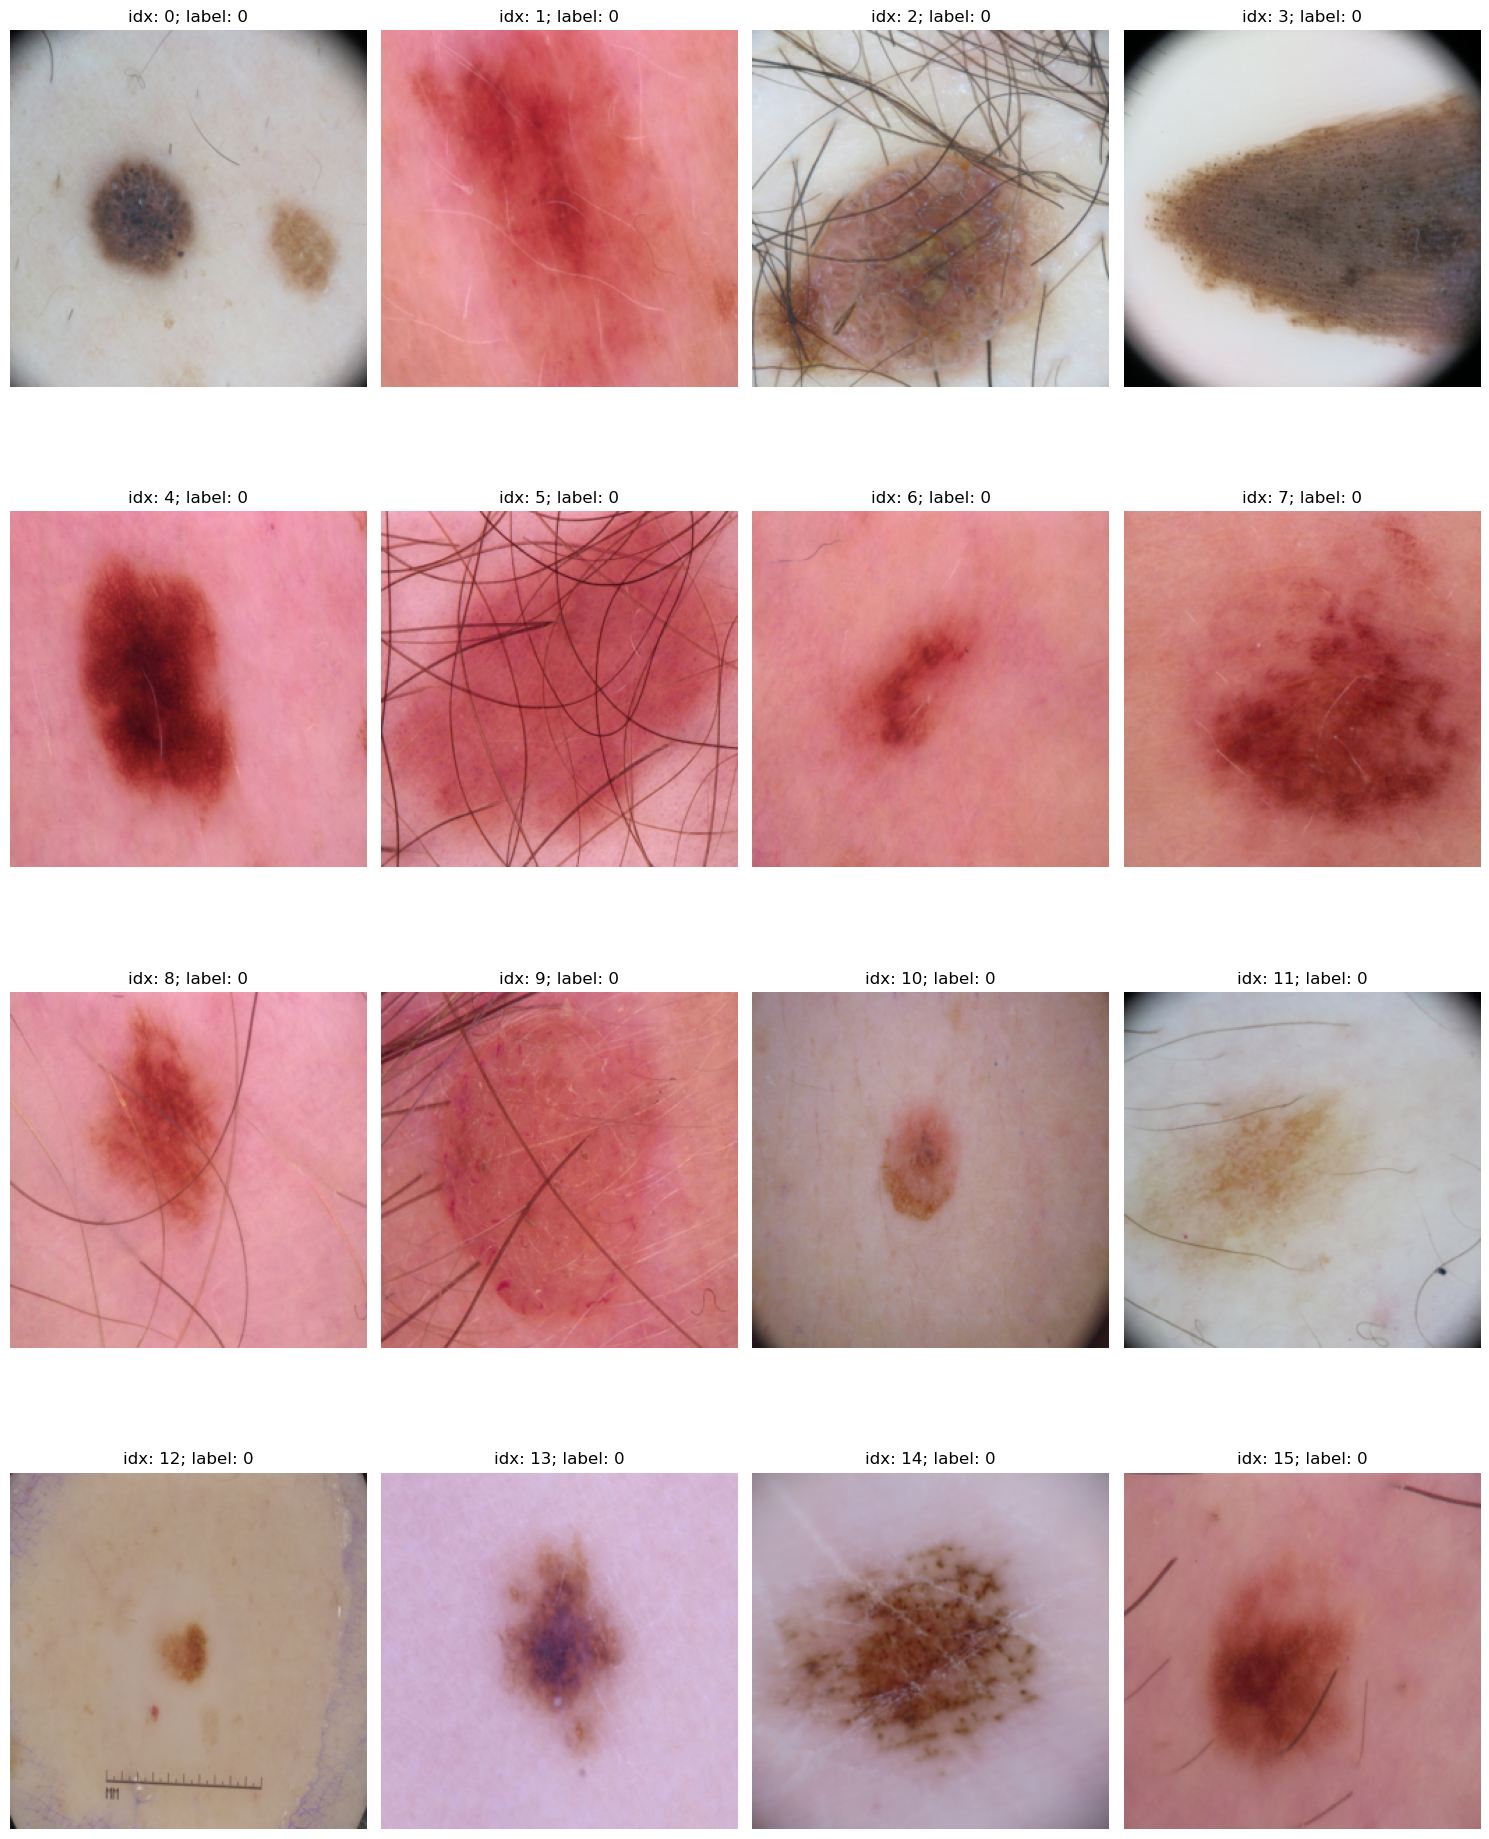

In [36]:
val_loader.show_images(34, False)

In [7]:
def count_image_dimensions(dataloader):
    dimension_count = {}

    # Iterate through the DataLoader
    for batch in dataloader:
        # Assuming the images are the first element of the batch (usually batch[0] in a tuple)
        images = batch[0]
        
        # Iterate through each image in the batch
        for img in images:
            # Get the image dimensions (height, width), assuming the image is in CHW format
            _, height, width = img.shape
            
            # Use the dimensions as a key in the dictionary
            dimensions = (height, width)
            
            # Count the occurrences of each dimension
            if dimensions in dimension_count:
                dimension_count[dimensions] += 1
            else:
                dimension_count[dimensions] = 1

    return dimension_count

# Example usage
# Assuming you have a PyTorch DataLoader `my_dataloader`
# dimension_count = count_image_dimensions(my_dataloader)
# print(dimension_count)


### COUNTS AND RATIO

In [8]:
import os
NEV_PATH = os.path.join(VAL_PATH, "nevus")
OTH_PATH = (os.path.join(VAL_PATH, "others"))

print(f"NEVUS: {len(os.listdir(NEV_PATH))}")
print(f"OTHERS: {len(os.listdir(OTH_PATH))}")
print(f"Ratio Nevus/Others: {len(os.listdir(NEV_PATH)) / len(os.listdir(OTH_PATH))}")

NEVUS: 1931
OTHERS: 1865
Ratio Nevus/Others: 1.0353887399463806


### SHAPES

In [22]:
import logging

nev_dimension_count = {}
oth_dimension_count = {}

for idx, file in enumerate(os.listdir(NEV_PATH)):

    if os.path.splitext(file)[1] != ".jpg":
        logging.warning(f"File {file} at index {idx} is not a .jpeg")
        continue
    img = cv.imread(os.path.join(NEV_PATH, file), cv.IMREAD_UNCHANGED)
    
    shape = str(img.shape )   
    
    if shape not in nev_dimension_count:
        nev_dimension_count[shape] = 1
    
    nev_dimension_count[shape] += 1


for idx, file in enumerate(os.listdir(OTH_PATH)):
    if os.path.splitext(file)[1] != ".jpg":
        logging.warning(f"File {file} at index {idx} is not a .jpeg")
        continue
    
    img = cv.imread(os.path.join(OTH_PATH, file), cv.IMREAD_UNCHANGED)
    
    shape = str(img.shape)   
    
    if shape not in oth_dimension_count:
        oth_dimension_count[shape] = 1
    
    oth_dimension_count[shape] += 1    

#### NEVUS DIMS

In [29]:
nev_dimension_count

{'(1024, 1024, 3)': 646,
 '(450, 600, 3)': 984,
 '(680, 1024, 3)': 92,
 '(686, 1024, 3)': 5,
 '(768, 1024, 3)': 92,
 '(681, 1024, 3)': 8,
 '(682, 1024, 3)': 28,
 '(642, 958, 3)': 2,
 '(683, 1024, 3)': 8,
 '(685, 1024, 3)': 20,
 '(679, 1024, 3)': 13,
 '(690, 1024, 3)': 2,
 '(716, 1024, 3)': 4,
 '(802, 919, 3)': 7,
 '(678, 1024, 3)': 3,
 '(676, 1024, 3)': 3,
 '(677, 1024, 3)': 5,
 '(674, 1024, 3)': 2,
 '(674, 962, 3)': 2,
 '(684, 1024, 3)': 4,
 '(722, 962, 3)': 2,
 '(645, 966, 3)': 2,
 '(768, 576, 3)': 3,
 '(576, 767, 3)': 8,
 '(717, 1019, 3)': 2,
 '(914, 1024, 3)': 2,
 '(719, 824, 3)': 2,
 '(542, 718, 3)': 2,
 '(767, 1022, 3)': 3,
 '(710, 1024, 3)': 2,
 '(670, 962, 3)': 2,
 '(673, 1024, 3)': 2,
 '(634, 959, 3)': 2}

#### OTHERS DIMS

In [23]:
oth_dimension_count

{'(1024, 1024, 3)': 1227,
 '(450, 600, 3)': 496,
 '(680, 1024, 3)': 73,
 '(764, 1024, 3)': 12,
 '(679, 1024, 3)': 5,
 '(685, 1024, 3)': 8,
 '(683, 1024, 3)': 3,
 '(682, 1024, 3)': 2,
 '(768, 1024, 3)': 31,
 '(576, 767, 3)': 4,
 '(602, 639, 3)': 2,
 '(677, 1024, 3)': 2,
 '(719, 824, 3)': 2,
 '(802, 919, 3)': 4,
 '(684, 1024, 3)': 3,
 '(542, 722, 3)': 2,
 '(767, 1022, 3)': 2,
 '(681, 1024, 3)': 3,
 '(678, 1024, 3)': 2,
 '(1024, 857, 3)': 2}

CONCLUSION is that we need to pad the images to 1024x1024 at first

## SQUARE INPUTS WITH SPACIAL FEATURES KEPT (padded)

In [55]:
def pad_to_square(image):
    width, height = image.size
    
    # Determine the size of the new square (the larger of the two dimensions)
    max_dim = max(width, height)
    
    # Calculate padding for width and height to make it a square
    pad_left = (max_dim - width) // 2
    pad_right = max_dim - width - pad_left
    pad_top = (max_dim - height) // 2
    pad_bottom = max_dim - height - pad_top
    
    # Apply padding
    transform = Pad((pad_left, pad_top, pad_right, pad_bottom), fill=0)
    return transform(image)

In [56]:
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"

transform = transforms.Compose([
    transforms.Lambda(pad_to_square),    # Pad the image to a square
    transforms.Resize((256, 256)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

val_loader_padded: Loader = utl.Loader(VAL_PATH, transform=transform)

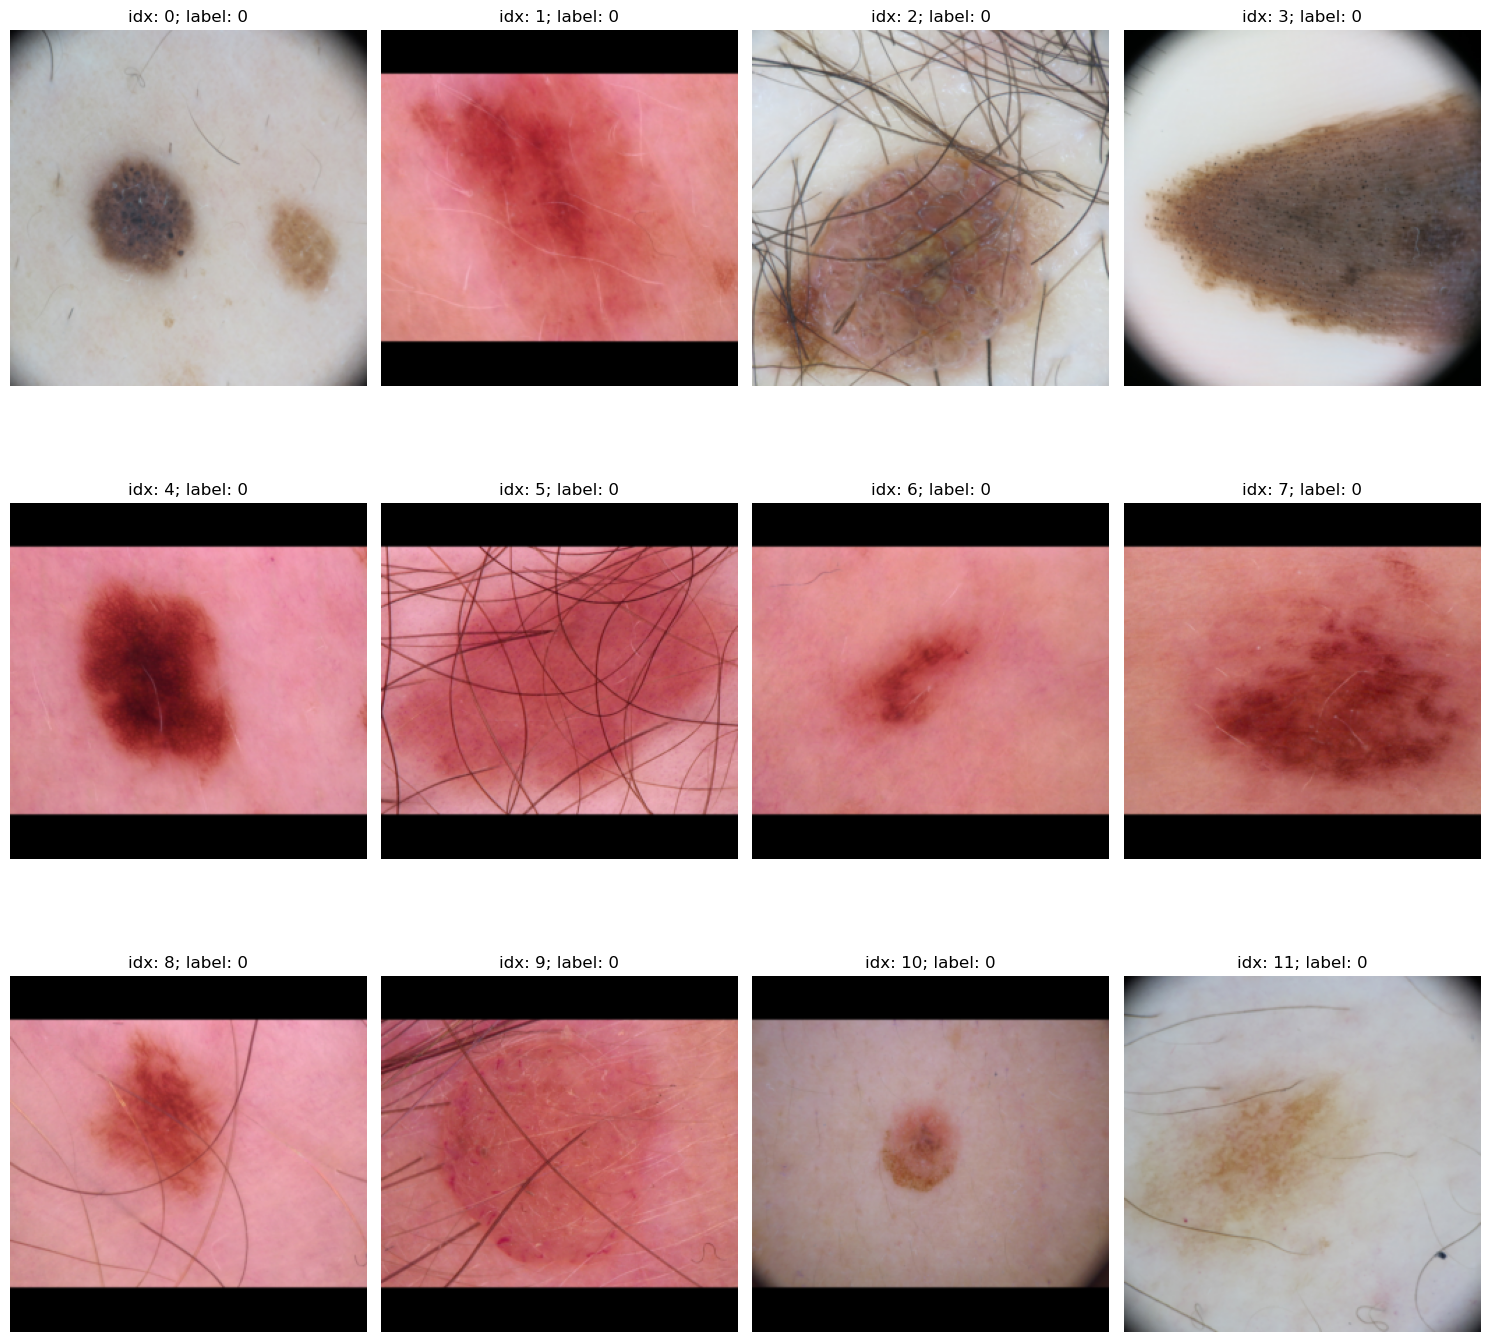

In [57]:
val_loader_padded.show_images(12)